In [111]:
%%bash
pip install pandas matplotlib seaborn jupyter jupytext

In [112]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
import pathlib
import re
from typing import Dict, List, Any
from copy import deepcopy
plt.style.use("./plt_plot_style.mplstyle")

In [113]:
def load_results(f_name: str):
    f_name = pathlib.Path.cwd().parent / f_name
    with open(f_name, "rb") as handle:
        return pickle.load(handle)

results = {s: None for s in [0.8, 0.9, 0.95, 0.99]}
for s in results.keys():
    results[s] = load_results(f"benchmark_{s}.pkl")
results

{0.8: <torch.utils.benchmark.utils.compare.Compare at 0x7fc81d901f90>,
 0.9: <torch.utils.benchmark.utils.compare.Compare at 0x7fc81d903c70>,
 0.95: <torch.utils.benchmark.utils.compare.Compare at 0x7fc823a65150>,
 0.99: <torch.utils.benchmark.utils.compare.Compare at 0x7fc81d92ca60>}

In [131]:
def compare_to_df(compare: torch.utils.benchmark.utils.compare.Compare, schema: Dict[str, List[Any]]) -> pd.DataFrame:
    schema = deepcopy(schema)
    description_map = {
        "dense": "Dense",
        "dense_compiled": "Dense.compile()",
    }
    for measurement in compare._results:
        bs = re.match(".*bs=([0-9].*)", measurement.title).groups()[0]
        sparsity = re.match(".*\@\s([0-9]*\.[0-9]*)", measurement.description)
        if sparsity is not None:
            sparsity = sparsity.groups()[0]
        
        desc = description_map[measurement.description] if sparsity is None else f"FFI @ {sparsity}% sparsity"
        schema["description"].append(desc)
        # schema["sparsity"].append(int(float(sparsity)*100))
        schema["batch_size"].append(int(bs))
        schema["time"].append(measurement.median*1000)
        schema["std"].append(np.std(measurement.times)*1000)
    df = pd.DataFrame(schema)
    return df
        
schema = {
    "batch_size": [],
    "time": [],
    "std": [],
    "description": []
}
df = pd.DataFrame(schema)
for s in results.keys():
    df = pd.concat([df, compare_to_df(results[s], schema)], axis=0)
df = df.groupby(["batch_size", "description"]).mean().reset_index()
df

,batch_size,description,time,std
0,2.0,Dense,339.417675,0.000000
1,2.0,Dense.compile(),236.201588,151.828333
2,2.0,FFI @ 0.8% sparsity,807.242608,5.070313
3,2.0,FFI @ 0.9% sparsity,575.358777,5.684983
4,2.0,FFI @ 0.95% sparsity,491.847612,7.540011
5,2.0,FFI @ 0.99% sparsity,403.467181,7.503659
6,4.0,Dense,691.555607,0.000000
7,4.0,Dense.compile(),474.913505,361.777547
8,4.0,FFI @ 0.8% sparsity,1686.579042,3.702555
9,4.0,FFI @ 0.9% sparsity,1223.669044,4.240353


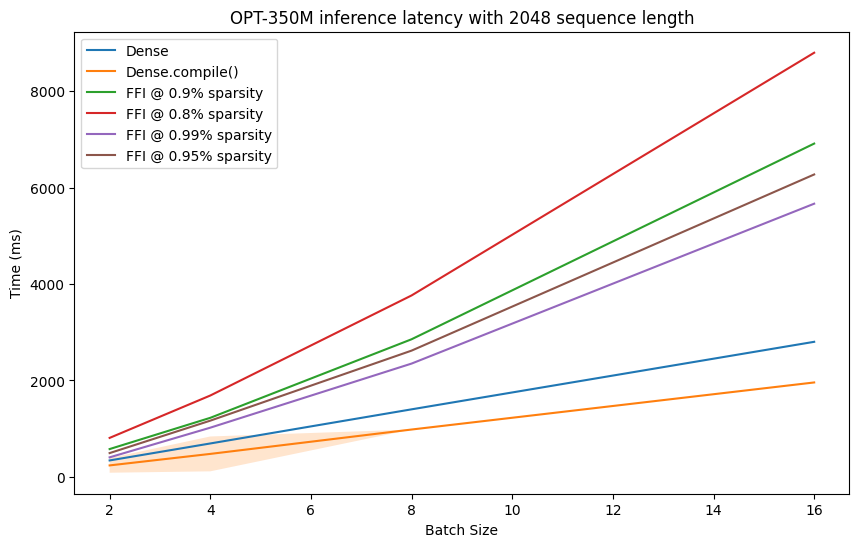

In [134]:
fig, ax = plt.subplots(figsize=(10,6))
df = df.sort_values(by='description').sort_values(by="batch_size", ascending=True)
_COLOURS = sns.color_palette("tab10").as_hex()
for i, desc in enumerate(df['description'].unique()):
    colour = _COLOURS[i]
    slice = df.loc[df['description']==desc]
    ax.plot(slice['batch_size'], slice['time'], label=desc, color=colour)
    ax.fill_between(
        slice["batch_size"],
        slice["time"]+slice["std"],
        slice["time"]-slice["std"],
        alpha=0.2
        )
plt.legend()
plt.ylabel("Time (ms)")
plt.xlabel("Batch Size")
plt.title("OPT-350M inference latency with 2048 sequence length")
fig.savefig(f"benchmark_results.svg", dpi=600, transparent=False)
fig.savefig(f"benchmark_results.png", dpi=600, transparent=False)